In [ ]:
# install needed stuff for running in sagemaker on aws
# https://forums.fast.ai/t/importerror-cannot-import-name-as-tensor/25295/3

!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!pip install torchtext
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

In [ ]:
!pip show Pillow

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [11]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [12]:
PATH='data/'

In [13]:
files = os.listdir(f'{PATH}valid/himbeere')
files

['download (10).jpeg',
 'download.jpeg',
 'download (9).jpeg',
 'download (8).jpeg']

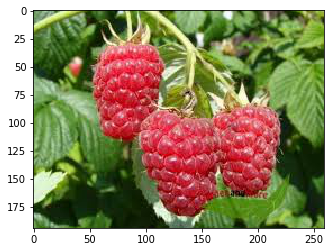

In [18]:
img = plt.imread(f'{PATH}/valid/himbeere/{files[1]}')
plt.imshow(img);

In [19]:
img.shape

(194, 259, 3)

In [25]:
# create first simple retrained network
# sz = image size?
arch = resnet34
sz = 224
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz=sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
# fit network where 0.01 is the learning rate and 2 is the cycle length
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy       
    0      1.040653   0.793829   0.461538  
    1      0.968782   0.698036   0.615385        



[array([0.69804]), 0.6153846153846154]

In [57]:
# data augmentation to generate more pictures
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.3)

In [58]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[0]

ims = np.stack([get_augs() for i in range(6)])

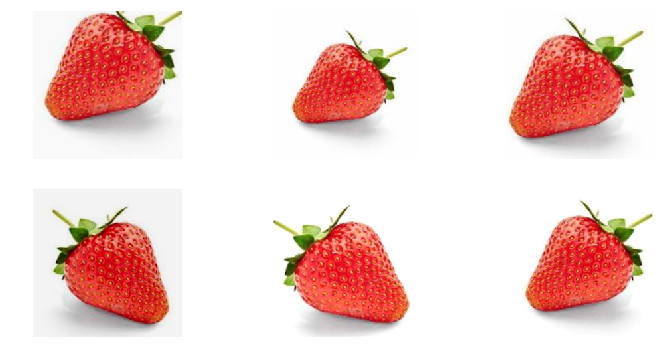

In [59]:
plots(ims, rows=2)

In [60]:
# lets train again but with augmatentation picutres
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, pretrained=True)

In [61]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy               
    0      1.176234   0.857651   0.307692  
    1      0.853633   0.634789   0.769231        



[array([0.63479]), 0.7692307692307693]

In [62]:
learn.fit(0.01, 6, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.674887   0.631721   0.769231  
    1      0.60886    0.608495   0.846154                
    2      0.629646   0.551719   0.846154               
    3      0.539063   0.533424   0.846154                
    4      0.492822   0.479525   0.846154                
    5      0.503895   0.454834   0.846154                
    6      0.470595   0.409376   0.846154                
    7      0.430376   0.386671   0.846154               
    8      0.396254   0.36013    0.846154                
    9      0.36809    0.347628   0.846154                
    10     0.345096   0.333748   0.846154                
    11     0.32312    0.326879   0.846154        



[array([0.32688]), 0.8461538461538461]

In [63]:
learn.unfreeze()

In [64]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [65]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.186421   0.30051    0.846154  
    1      0.317548   0.284248   0.846154                
    2      0.387857   0.292785   0.846154                
    3      0.334382   0.284462   0.846154                
    4      0.287723   0.273592   0.846154                
    5      0.267289   0.244381   0.846154                
    6      0.266675   0.229681   0.923077        



[array([0.22968]), 0.9230769230769231]

In [75]:
log_preds, y = learn.TTA()

In [78]:
probabbility = np.mean(np.exp(log_preds),0)

In [80]:
accuracy_np(probabbility, y)

0.8461538461538461

[[8 1]
 [1 3]]


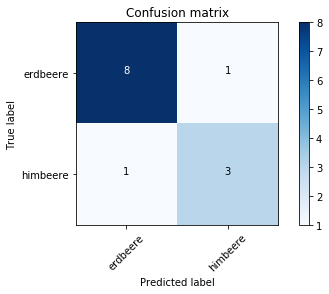

In [86]:
# change it to 0 and 1 for true and false
preds = np.argmax(probabbility, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [91]:
# show me false predicted images

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Erdbeere


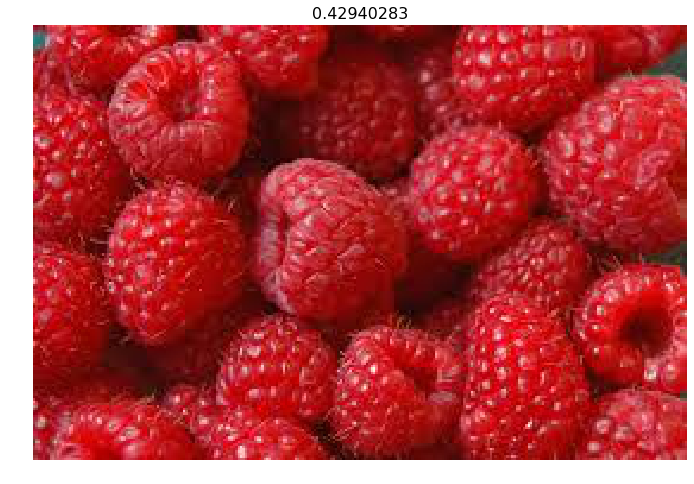

In [103]:
plot_val_with_title(most_by_correct(1, False), "Erdbeere")

Himbeere


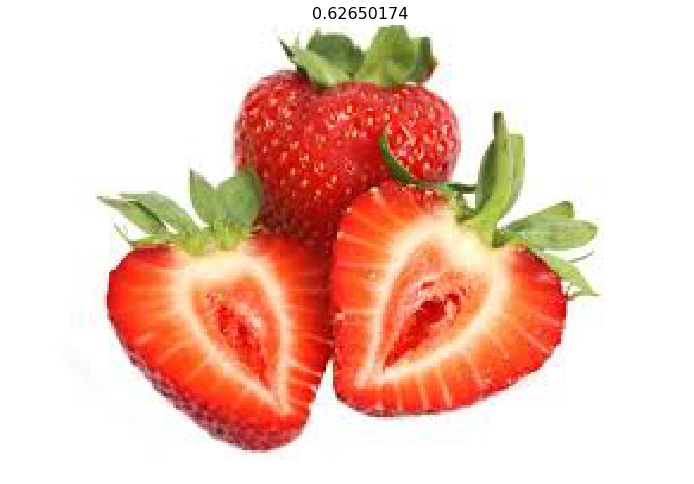

In [99]:
plot_val_with_title(most_by_correct(0, False), "Himbeere")